# The Payne Tutorial

Follow the instructions from https://github.com/tingyuansen/The_Payne/tree/master:


```bash
cd /path/were/you/want/to/install/The_Payne/
git clone https://github.com/tingyuansen/The_Payne.git
cd The_Payne
python setup.py install
```


In [1]:
import numpy as np
from astropy.table import Table, hstack
from astropy.io import fits
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

In [2]:
from The_Payne import training
from The_Payne import utils
from The_Payne import spectral_model

# """
# Changes that need to be made to training.py in The_Payne if no CUDA is available
"""
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    dtype = torch.FloatTensor
    torch.set_default_tensor_type('torch.FloatTensor')
    
if torch.cuda.is_available():
    model.cuda()
        
if torch.cuda.is_available():
    perm = perm.cuda()
    
if torch.cuda.is_available():
    perm_valid = perm_valid.cuda()
"""

# I have also adjusted the output names to be a keyword argument.
# If you want that too, you would need to search->replace:
"""
def neural_net(training_labels, training_spectra, validation_labels, validation_spectra,\
         num_neurons = 300, num_steps=1e4, learning_rate=1e-4, batch_size=512,\
         num_features = 64*5, mask_size=11, num_pixel=7214,
         training_loss_name = "training_loss.npz",
         payne_model_name = "NN_normalized_spectra.npz"
         ):
"training_loss.npz" -> training_loss_name
"NN_normalized_spectra.npz" -> payne_model_name
""";

# Select labels and download spectra (already done in github)

In [4]:
# I have already done this step for the github repository, so no need to do that again.
# spectra are saved in spectra/

prepare_again = False

if prepare_again:
    galah_dr3 = Table.read('/Users/buder/GALAH_DR3/catalogs/GALAH_DR3_main_allstar_v2.fits')

    elements_to_fit = [
    #     'Li','C',
        'O','Na','Mg','Al','Si',
        'K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn',
    #     'Rb','Sr',
        'Y',
    #     'Zr','Mo','Ru',
        'Ba','La',    
    #     'Ce','Nd','Sm',
        'Eu'
    ]

    galah_dr3_subset_giants = galah_dr3[
        (galah_dr3['flag_sp'] == 0) &
        (galah_dr3['flag_fe_h'] == 0) &
        (galah_dr3['snr_c1_iraf'] > 25) &
        (galah_dr3['snr_c2_iraf'] > 25) &
        (galah_dr3['snr_c3_iraf'] > 25) &
        (galah_dr3['snr_c4_iraf'] > 25) &
        (galah_dr3['logg'] < 3.) &
        np.all([galah_dr3['flag_'+element+'_fe'] == 0 for element in elements_to_fit], axis=0)
    ]
    galah_dr3_subset_dwarfs = galah_dr3[
        (galah_dr3['flag_sp'] == 0) &
        (galah_dr3['flag_fe_h'] == 0) &
        (galah_dr3['snr_c1_iraf'] > 25) &
        (galah_dr3['snr_c2_iraf'] > 25) &
        (galah_dr3['snr_c3_iraf'] > 25) &
        (galah_dr3['snr_c4_iraf'] > 25) &
        (galah_dr3['logg'] > 3.5) &
        np.all([galah_dr3['flag_'+element+'_fe'] == 0 for element in elements_to_fit], axis=0)
    ]
    galah_dr3_subset_subgiants = galah_dr3[
        (galah_dr3['flag_sp'] == 0) &
        (galah_dr3['flag_fe_h'] == 0) &
        (galah_dr3['snr_c1_iraf'] > 25) &
        (galah_dr3['snr_c2_iraf'] > 25) &
        (galah_dr3['snr_c3_iraf'] > 25) &
        (galah_dr3['snr_c4_iraf'] > 25) &
        (galah_dr3['logg'] > 3.0) &
        (galah_dr3['logg'] < 3.75) &
        np.all([galah_dr3['flag_'+element+'_fe'] == 0 for element in elements_to_fit], axis=0)
    ]

    np.random.seed(712)
    random_45_giants_subset = np.random.randint(len(galah_dr3_subset_giants['teff']), size=45)
    random_10_subgiants_subset = np.random.randint(len(galah_dr3_subset_subgiants['teff']), size=10)
    random_45_dwarfs_subset = np.random.randint(len(galah_dr3_subset_dwarfs['teff']), size=45)

    training_set_label_table = Table()
    for key in ['sobject_id','teff','logg','fe_h','vbroad','vmic']:
        training_set_label_table[key] = np.concatenate((
            galah_dr3_subset_giants[key][random_45_giants_subset],
            galah_dr3_subset_subgiants[key][random_10_subgiants_subset],
            galah_dr3_subset_dwarfs[key][random_45_dwarfs_subset],
        ))
        
    training_label_table.write('GALAH_DR3_100_labels.fits',overwrite=True)
    
    for sobject_id in training_set_label_table['sobject_id']:
        os.system('rsync -azu galah@galahobs.datacentral.org.au:/galah/DR3/data/galah/dr3/spectra/'+str(sobject_id)+'1.fits spectra/')
        os.system('rsync -azu galah@galahobs.datacentral.org.au:/galah/DR3/data/galah/dr3/spectra/'+str(sobject_id)+'2.fits spectra/')
        os.system('rsync -azu galah@galahobs.datacentral.org.au:/galah/DR3/data/galah/dr3/spectra/'+str(sobject_id)+'3.fits spectra/')
        os.system('rsync -azu galah@galahobs.datacentral.org.au:/galah/DR3/data/galah/dr3/spectra/'+str(sobject_id)+'4.fits spectra/')

# Curate data for The Payne

In [38]:
training_set_label_table = Table.read('GALAH_DR3_100_labels.fits')
# put all the labels (i.e. the ones that are not sobject_id) into an array

labels = ['teff','logg','fe_h','vbroad','vmic']

training_set_labels = np.array([list(training_set_label_table[key]) for key in labels]).T

print('Using the following labels:')
print(labels)

Using the following labels:
['teff', 'logg', 'fe_h', 'vbroad', 'vmic']


In [39]:
wavelengths_ccds = dict()
wavelengths_ccds['1']=np.arange(4715.94,4896.00,0.046)
wavelengths_ccds['2']=np.arange(5650.06,5868.25,0.055)
wavelengths_ccds['3']=np.arange(6480.52,6733.92,0.064)
wavelengths_ccds['4']=np.arange(7693.50,7875.55,0.074)

In [31]:
training_set_wavelength = np.concatenate(([wavelengths_ccds[ccd] for ccd in ['1','2','3','4']]))
training_set_flux = []
training_set_flux_uncertainty = []

for sobject_id in training_set_label_table['sobject_id']:
    flux_per_spectrum = []
    flux_uncertainty_per_spectrum = []
    for ccd in ['1','2','3','4']:
        fits_file = fits.open('spectra/'+str(sobject_id)+ccd+'.fits')
        wavelength_raw = fits_file[4].header['CRVAL1'] + fits_file[4].header['CDELT1'] * np.arange(fits_file[4].header['NAXIS1'])
        flux_per_spectrum.append(
            np.array(np.interp(wavelengths_ccds[ccd], wavelength_raw, fits_file[4].data).clip(min=0.01,max=1.2))
        )
        flux_uncertainty_per_spectrum.append(
            np.array(np.interp(wavelengths_ccds[ccd], wavelength_raw, fits_file[1].data * fits_file[4].data).clip(min=0.001))
        )
        fits_file.close()
    training_set_flux.append(np.concatenate((flux_per_spectrum)))
    training_set_flux_uncertainty.append(np.concatenate((flux_uncertainty_per_spectrum)))

training_set_flux = np.array(training_set_flux)
training_set_flux_uncertainty = np.array(training_set_flux_uncertainty)

# Train The Payne

In [32]:
# Divide the set into training set (80%) and validation set (20%)
train, test = train_test_split(np.arange(np.shape(training_set_flux)[0]), test_size=0.20, random_state=8876)

In [33]:
# Now train the model
model_file = 'galah_tutorial'
training.neural_net(
    training_labels = training_set_labels[train,:], 
    training_spectra = training_set_flux[train,:],
    validation_labels = training_set_labels[test,:], 
    validation_spectra = training_set_flux[test,:],
    num_neurons=20,
    learning_rate=1e-4,
    num_steps=3e3,
    batch_size=2,
    num_pixel=np.shape(training_set_flux[0])[0],
    training_loss_name = model_file+'_loss.npz',
    payne_model_name = model_file+'.npz'
    )

iter 0: training loss = 9357.047 validation loss = 9236.573
iter 100: training loss = 308.520 validation loss = 299.257
iter 200: training loss = 243.037 validation loss = 228.576
iter 300: training loss = 177.560 validation loss = 189.085
iter 400: training loss = 142.001 validation loss = 162.459
iter 500: training loss = 162.929 validation loss = 153.967
iter 600: training loss = 337.310 validation loss = 151.482
iter 700: training loss = 110.870 validation loss = 151.782
iter 800: training loss = 155.040 validation loss = 152.128
iter 900: training loss = 171.146 validation loss = 154.044
iter 1000: training loss = 109.406 validation loss = 155.973
iter 1100: training loss = 121.636 validation loss = 156.994
iter 1200: training loss = 132.962 validation loss = 157.904
iter 1300: training loss = 112.165 validation loss = 157.880
iter 1400: training loss = 106.377 validation loss = 160.265
iter 1500: training loss = 132.942 validation loss = 158.942
iter 1600: training loss = 131.732

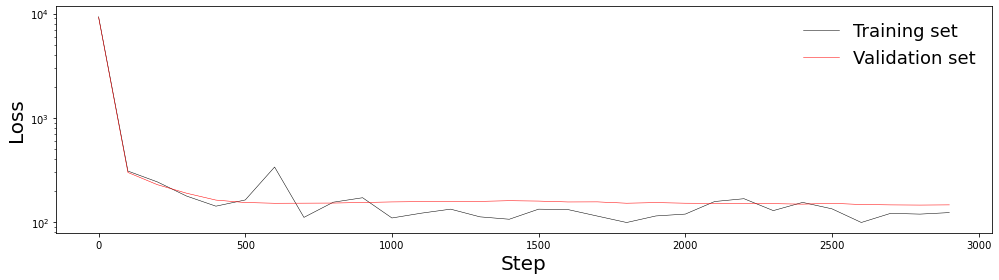

In [34]:
# Plot the loss functions for training and validation

training_loss = np.load(model_file+'_loss.npz') # the output array also stores the training and validation loss

plt.figure(figsize=(14, 4))
plt.plot(np.arange(training_loss['training_loss'].size)*100, training_loss['training_loss'], 'k', lw=0.5, label = 'Training set')
plt.plot(np.arange(training_loss['validation_loss'].size)*100, training_loss['validation_loss'], 'r', lw=0.5, label = 'Validation set')
plt.legend(loc = 'best', frameon = False, fontsize= 18)
plt.yscale('log')
plt.xlabel("Step", size=20)
plt.ylabel("Loss", size=20)
plt.tight_layout()

# Using the trained model

In [73]:
NN_coeffs = np.load(model_file+'.npz')

def leaky_relu(z):
    '''
    This is the activation function used by default in all our neural networks.
    '''
    return z*(z > 0) + 0.01*z*(z < 0)

def get_spectrum_from_neural_net(scaled_labels, NN_coeffs):
    '''
    Predict the rest-frame spectrum (normalized) of a single star.
    We input the scaled stellar labels (not in the original unit).
    Each label ranges from -0.5 to 0.5
    '''

    # assuming your NN has two hidden layers.
    w_array_0 = NN_coeffs['w_array_0']
    w_array_1 = NN_coeffs['w_array_1']
    w_array_2 = NN_coeffs['w_array_2']
    b_array_0 = NN_coeffs['b_array_0']
    b_array_1 = NN_coeffs['b_array_1']
    b_array_2 = NN_coeffs['b_array_2']
    x_min = NN_coeffs['x_min']
    x_max = NN_coeffs['x_max']
    
    inside = np.einsum('ij,j->i', w_array_0, scaled_labels) + b_array_0
    outside = np.einsum('ij,j->i', w_array_1, leaky_relu(inside)) + b_array_1
    spectrum = np.einsum('ij,j->i', w_array_2, leaky_relu(outside)) + b_array_2
    return spectrum

In [79]:
def calculate_spectrum(labels, NN_coeffs):

    scaled_labels = (example_labels-NN_coeffs['x_min'])/(NN_coeffs['x_max']-NN_coeffs['x_min']) - 0.5
    spectrum = get_spectrum_from_neural_net(scaled_labels = scaled_labels, NN_coeffs = neural_network_coefficients)
    
    return(spectrum)

In [115]:
def plot_spectrum(spectrum, labels, comparison_spectrum=None):
    f, gs = plt.subplots(4,1,figsize=(12,8))
    for ccd in [1,2,3,4]:
        ax = gs[ccd-1]

        in_ccd = (training_set_wavelength > ((3+ccd)*1000)) & (training_set_wavelength < ((4+ccd)*1000))

        ax.plot(
            training_set_wavelength[in_ccd],
            spectrum[in_ccd],
            label = 'The Payne',
            zorder = 2,
            c = 'C0'
        )
        
        if comparison_spectrum is not None:
            ax.plot(
                training_set_wavelength[in_ccd],
                comparison_spectrum[in_ccd],
                label = 'Observed',
                zorder = 1,
                c = 'k', lw=1
            )
            ax.plot(
                training_set_wavelength[in_ccd],
                np.abs(comparison_spectrum[in_ccd] - spectrum[in_ccd]),
                label = 'Residuals',
                zorder = 3,
                c = 'C1', lw=1
            )
            
        if ccd == 1:
            ax.legend(ncol=3)
        if ccd == 4:
            ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$')
        ax.set_ylabel('Flux / norm.')
        ax.set_ylim(0,1.2)
        
    plt.tight_layout()
    plt.show()
    plt.close()

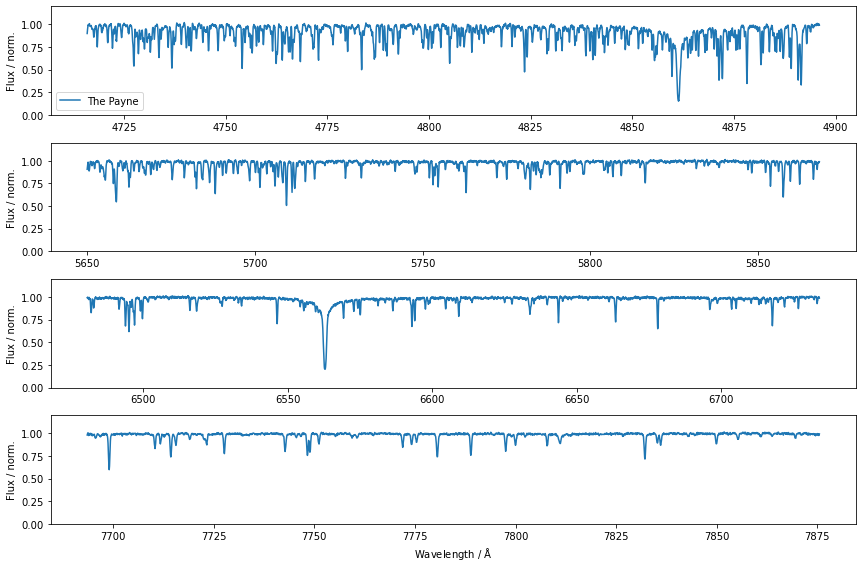

In [116]:
example_labels = np.array([5772, 4.44, 0.00, 5.0, 1.55], dtype=float)
example_spectrum = calculate_spectrum(example_labels, NN_coeffs)
plot_spectrum(example_spectrum, example_labels, comparison_spectrum = None)

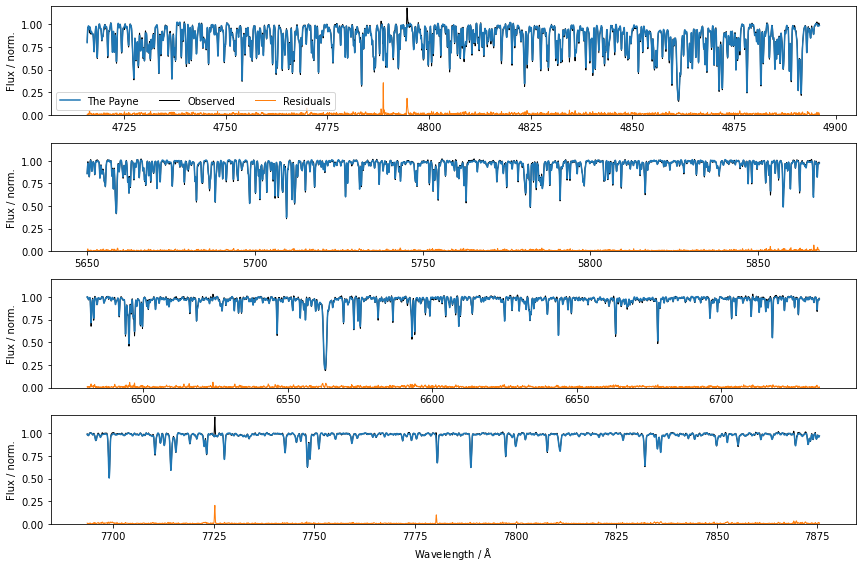

In [117]:
example_labels = training_set_labels[0]
example_spectrum = calculate_spectrum(example_labels, NN_coeffs)
plot_spectrum(example_spectrum, example_labels, comparison_spectrum = training_set_flux[0])